In [1]:
import ml
reload(ml)
from ml import *
import json
import timeit
import numba
import scipy
import swifter
import operator
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import permutation_test as p
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.ensemble import VotingClassifier
from mlxtend.evaluate import permutation_test
from __future__ import division
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

__author__ = 'HK Dambanemuya'
__version__ = 'Python 2'

'''
    Analysis originaly performed in Python 2 (deprecated)
    Seaborn, Statsmodel, and * imports broken in Python 3
'''

In [2]:
with open("../Data/listing_keys.txt") as file:
    listing_keys = json.load(file)

In [3]:
data = pd.read_csv('../Data/bid_notick.txt', sep="|")
data = data.drop(labels='Unnamed: 11', axis=1)
data = data[data.ListingStatus=="Completed"]
data.head()

,Amount,CreationDate,Bid_Key,ListingKey,ListingStatus,MemberKey,MinimumRate,MinimumYield,ParticipationAmount,Status,ModifiedDate
0,50.000,2006-02-21 20:23:20,0F12336634427919902FE93,D6473365888221963456102,Completed,F4273365023760472DBD934,0.250,0.245,0.000,Outbid,2006-02-21 20:23:20
1,50.000,2006-02-21 22:50:00,87F333655285187004B2EE8,D6473365888221963456102,Completed,F4273365023760472DBD934,nan,nan,50.000,Winning,2006-02-21 22:50:00
3,50.000,2006-02-28 20:06:43,7284336544796747049D125,601833660859080305A2AC3,Completed,F4273365023760472DBD934,0.069,0.064,0.000,Outbid,2006-02-28 20:06:43
4,50.000,2006-03-01 09:27:50,F3FD3365245307569E84B9F,601833660859080305A2AC3,Completed,F4273365023760472DBD934,nan,nan,50.000,Winning,2006-03-01 09:27:50
5,50.000,2006-02-23 17:06:04,D95833652448711959A6199,73AB3364393429683903176,Completed,F4273365023760472DBD934,0.080,0.074,0.000,Outbid,2006-02-23 17:06:04


In [4]:
data = data[data.ListingKey.isin(listing_keys.get("Values"))]
len(data)

3948660

In [5]:
data = data[data.Status.isin(['Partially Participating', 'Winning'])]
len(data)

2029950

In [6]:
data.head()

,Amount,CreationDate,Bid_Key,ListingKey,ListingStatus,MemberKey,MinimumRate,MinimumYield,ParticipationAmount,Status,ModifiedDate
1,50.000,2006-02-21 22:50:00,87F333655285187004B2EE8,D6473365888221963456102,Completed,F4273365023760472DBD934,nan,nan,50.000,Winning,2006-02-21 22:50:00
4,50.000,2006-03-01 09:27:50,F3FD3365245307569E84B9F,601833660859080305A2AC3,Completed,F4273365023760472DBD934,nan,nan,50.000,Winning,2006-03-01 09:27:50
8,50.000,2006-04-25 22:51:48,672D33652553594927B290D,9AF5336547891402212A6FC,Completed,F4273365023760472DBD934,nan,nan,50.000,Winning,2006-04-25 22:51:48
9,67.270,2006-07-14 15:25:34,435C3366364364600E80F73,510133648179460628B9387,Completed,F4273365023760472DBD934,nan,nan,67.270,Winning,2006-07-14 15:25:34
11,50.000,2006-06-20 12:34:11,4C553365051125315AC8EF1,F8FA336539551257009155F,Completed,F4273365023760472DBD934,nan,nan,50.000,Winning,2006-06-20 12:34:11


In [7]:
data.MemberKey.nunique()

50264

In [8]:
# Import features
with open("../Data/features.txt") as file:
    features = json.load(file)
# Initialize Standard Scaler
scaler = StandardScaler() 
# Initialize Feature Values
feature_values = {}
# Import Data
data = pd.read_csv("../Data/prosper_final.csv")

In [9]:
data.head(5)

,ListingKey,FirstBidCreationDate,LastBidCreationDate,NoBids,AmountRequested,AvgInterBidTime,Gini,CV,DebtToIncomeRatio,DescriptionLength,...,ProsperRating,Friend_Count,Endorsement_Count,Role_Count,Group_Count,Watching,MemberCreationDate,TimeToFirstBid,TimeBetweenFirstLastBid,BorrowerAge
0,00033425227988088FA6752,2008-06-21 22:38:29,2008-06-23 06:08:09,15,1000.000,3101.733,0.167,0.352,0.190,190,...,0,1,1,3,3,3,2008-06-12 16:44:38,188.717,449.667,9
1,7B343428727859426204CF7,2008-08-05 19:49:08,2008-08-09 13:22:12,14,2200.000,22880.643,0.539,1.515,0.190,383,...,0,1,1,3,3,3,2008-06-12 16:44:38,75.767,1053.067,54
2,000433785890431972B4743,2007-01-03 09:11:14,2007-01-05 14:05:06,30,2550.000,8520.767,0.298,0.686,0.100,577,...,0,1,0,1,3,3,2006-05-10 16:13:00,1180.600,293.867,236
3,00083422661625108817246,2008-06-05 22:22:35,2008-06-12 22:03:28,141,3500.000,10633.589,0.198,0.608,0.350,210,...,0,1,0,1,3,3,2008-05-26 10:52:14,636.233,1420.883,0
4,000A34209897973969CFA81,2008-05-09 17:31:57,2008-05-15 15:17:26,2,1500.000,47348.000,0.468,0.935,0.040,134,...,0,1,0,2,3,3,2008-05-07 11:04:48,138.267,1305.483,1


In [10]:
print 'Final Listings:', len(data)
print 'Percent of Total Listings', ((28935/415157)*100)
print 'Total Bids:', np.sum(data.BidCount)
print 'Borrowers:', data.MemberKey.nunique()
print 'Date Range:', np.min(data.ListingStartDate), np.max(data.ListingStartDate)
print 'Average Loan Amount: $', np.mean(data.AmountRequested).round(2)
print 'Std Loan Amount:', np.std(data.AmountRequested).round()
print 'Total Loan Amount: $', np.sum(data.AmountRequested).round(2)
print 'Avg Interest Rate:', (np.mean(data.BorrowerMaximumRate)*100).round(1)

Final Listings: 28935
Percent of Total Listings 6.96965244474
Total Bids: 3948777
Borrowers: 26404
Date Range: 2005-11-09 20:44:28 2008-10-12 21:47:23
Average Loan Amount: $ 6170.96
Std Loan Amount: 5585.0
Total Loan Amount: $ 178556824.08
Avg Interest Rate: 21.2


## Mean Feature Values

In [11]:
data[features.get("Lender")+["RepaidOrNot"]].groupby("RepaidOrNot").agg(["mean", "std"]).T

RepaidOrNot                              0        1
CV                           mean 1.099    1.039   
                             std  0.669    0.633   
BidCount                     mean 129.352  140.620 
                             std  145.347  140.428 
TimeToFirstBid               mean 215.032  193.949 
                             std  363.064  354.311 
TimeBetweenFirstLastBid      mean 1002.996 1091.000
                             std  496.433  478.072 
LenderMedianAge              mean 131.944  144.415 
                             std  78.932   88.546  
LenderExperience             mean 1.452    1.472   
                             std  0.088    0.091   
MeanLenderBidAmountPerSecond mean 4.828    6.040   
                             std  11.623   11.496  
Herding1Coefficient          mean -0.032   -0.021  
                             std  0.329    0.305   
MaxLenderBidAmount           mean 1049.545 967.507 
                             std  1602.214 1495.877

In [12]:
print "Category, Defaulted, Paid"
for i in range(0,8):
    print i, Counter(data[data.Category == i]["RepaidOrNot"]).items()[0][1], Counter(data[data.Category == i]["RepaidOrNot"]).items()[1][1]


Category, Defaulted, Paid
0 6694 10245
1 1707 3351
2 198 423
3 707 1166
4 775 1620
5 152 322
6 78 249
7 345 903


## All Features

In [13]:
features.keys()

[u'Lender', u'Loan', u'All', u'Borrower']

In [14]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [15]:
X = data[features.get("All")].fillna(-1).as_matrix()
y = data['RepaidOrNot'].as_matrix()
classifier = classifiers.get("RF")
acc_scores = []
for i in range(0,100):
    if i%10==0:
        print i
    y_pred = run_cv(X,y,classifier)
    acc_scores.append(accuracy(y, y_pred))

In [16]:
# a, b, c = mean_confidence_interval(acc_scores)
mean_confidence_interval(acc_scores)

In [17]:
stats.ttest_1samp(acc_scores,0.69)

In [43]:
classifier = classifiers.get("RF")
all_values = {1:[],
              2:[],
              3:[],
              4:[],
              5:[],
              6:[]}
# print "CG Accuracy \t\t Precision \t\t Recall \t\t FM \t\t AUC"
for x in range(0,100):
    if x%10==0:
        print x
    for i in range(1,7):
        CG = data.query("Category == '{0}'".format(i)).fillna(-1).apply(pd.to_numeric, errors='coerce')
        X = CG[features.get("All")].as_matrix()
        X = scaler.fit_transform(X)
        y = CG['RepaidOrNot'].as_matrix()
        y_pred = run_cv(X,y,classifier)
        all_values[i].append(accuracy(y, y_pred))
#     print i, accuracy(y, y_pred), precision(y, y_pred), recall(y, y_pred), f1(y, y_pred), auc(y, y_pred)

0
10
20
30
40
50
60
70
80
90


## Borrower + Loan 

In [14]:
X = data[features.get("Borrower")+features.get("Loan")].fillna(-1).as_matrix()
y = data['RepaidOrNot'].as_matrix()
classifier = classifiers.get("RF")
bl_acc_scores = []
for i in range(0,100):
    if i%10==0:
        print i
    y_pred = run_cv(X,y,classifier)
    bl_acc_scores.append(accuracy(y, y_pred))

0
10
20
30
40
50
60
70
80
90


In [45]:
# a, b, c = mean_confidence_interval(acc_scores)
mean_confidence_interval(bl_acc_scores)

(0.7026493865560739, 0.7024220436751457, 0.7028767294370021)

In [46]:
stats.ttest_1samp(bl_acc_scores,0.714674961119751)

Ttest_1sampResult(statistic=-104.95753728228657, pvalue=2.6072923303303155e-103)

In [44]:
classifier = classifiers.get("RF")
bl_values = {1:[],
             2:[],
             3:[],
             4:[],
             5:[],
             6:[]}
# print "CG Accuracy \t\t Precision \t\t Recall \t\t FM \t\t AUC"
for x in range(0,100):
    if x%10==0:
        print x
    for i in range(1,7):
        CG = data.query("Category == '{0}'".format(i)).fillna(-1).apply(pd.to_numeric, errors='coerce')
        X = CG[features.get("Borrower")+features.get("Loan")].as_matrix()
        X = scaler.fit_transform(X)
        y = CG['RepaidOrNot'].as_matrix()
        y_pred = run_cv(X,y,classifier)
        bl_values[i].append(accuracy(y, y_pred))
#         print i, accuracy(y, y_pred), precision(y, y_pred), recall(y, y_pred), f1(y, y_pred), auc(y, y_pred)

0
10
20
30
40
50
60
70
80
90


### Accuracy Comparison

In [21]:
print(plt.style.available)

['seaborn-darkgrid', 'Solarize_Light2', 'seaborn-notebook', 'classic', 'seaborn-ticks', 'grayscale', 'bmh', 'seaborn-talk', 'dark_background', 'ggplot', 'fivethirtyeight', '_classic_test', 'seaborn-colorblind', 'seaborn-deep', 'seaborn-whitegrid', 'seaborn-bright', 'seaborn-poster', 'seaborn-muted', 'seaborn-paper', 'seaborn-white', 'fast', 'seaborn-pastel', 'seaborn-dark', 'tableau-colorblind10', 'seaborn', 'seaborn-dark-palette']


In [18]:
plt.style.use('classic')
N = 6
allMeans = [np.mean(all_values[i]) for i in range(1,7)]
allStd = [np.std(all_values[i]) for i in range(1,7)]

fig, ax = plt.subplots(figsize=(8, 6))

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, allMeans, width, color='#427BB0', yerr=allStd)


blMeans = [np.mean(bl_values[i]) for i in range(1,7)]
blStd = [np.std(bl_values[i]) for i in range(1,7)]
p2 = ax.bar(ind + width,blMeans, width,
            color='#A04334', yerr=blStd)

ax.set_xticks(ind + width)
ax.set_xticklabels(('Debt \nConsolidation', 
                    'Home \nImprovement', 
                    'Business \nExpenses', 
                    'Personal \nExpenses', 
                    'Student \nDebt', 
                    'Auto \nLoan'), rotation='vertical', size=13)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend((p1[0], p2[0]), 
          ('Borrower, Loan & Lender Features', 'Borrower & Loan Features'), 
          fontsize=13,
          loc='best')
ax.set_ylabel("Accuracy", size=13)

props = {'connectionstyle':'bar','arrowstyle':'-',\
             'shrinkA':20,'shrinkB':20,'linewidth':2}

ax.annotate("***", xy=(0.25,0.69), zorder=10)
ax.annotate('', xy=(0.0,0.68), xytext=(0.7,0.68), arrowprops=props, size=13)

ax.annotate("***", xy=(1.25,0.67), zorder=10)
ax.annotate('', xy=(1.0,0.66), xytext=(1.7,0.66), arrowprops=props)

ax.annotate("**", xy=(2.25,0.68), zorder=10)
ax.annotate('', xy=(2.0,0.67), xytext=(2.7,0.67), arrowprops=props)

ax.annotate("***", xy=(3.25,0.74), zorder=10)
ax.annotate('', xy=(3.0,0.73), xytext=(3.7,0.73), arrowprops=props)

ax.annotate("***", xy=(5.25,0.76), zorder=10)
ax.annotate('', xy=(5.0,0.75), xytext=(5.7,0.75), arrowprops=props)
    
    
# # Call the function
# # label_diff(0,1,'***',ind,allMeans)
# label_diff(1,2,'*',ind,menMeans)
# label_diff(2,3,'p=0.0025',ind,menMeans)


ax.autoscale_view()

rect = fig.patch
rect.set_facecolor('white')

plt.show()

In [21]:
sum(data[data["Category"]==0]["AmountRequested"])

105971218.08

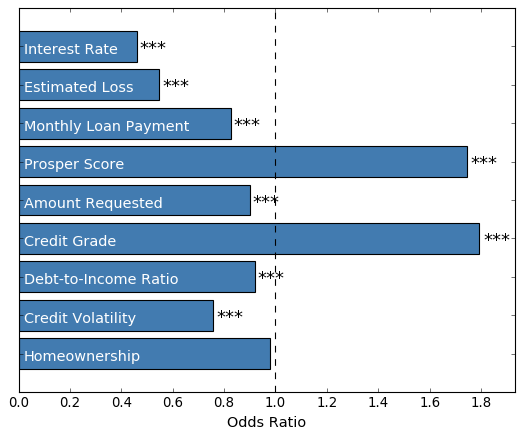

In [113]:
plt.style.use('classic')

fig, ax = plt.subplots(figsize=(8, 6))

# Example data
# variables = ('Interest Rate',  'Estimated Loss', 'Monthly Loan Payment', 'Prosper Score', 'Amount Requested',
#               'Credit Grade', 'Debt-to-Income Ratio', 'Credit Score Range', 'Homeownership')
variables = ('','','','','','','','','')
y_pos = np.arange(len(variables))
odds_ratios = [0.460, 0.545, 0.826, 1.744, 0.900, 1.791, 0.919, 0.757, 0.978]


plt.ylim(-1,9)
plt.xlim(0,1.93)
plt.axvline(x=1.0, color='k', linestyle='--')

ax.barh(y_pos, odds_ratios, align='center',
        color='#427BB0')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables, fontsize=16)
ax.set_xticks(np.arange(0,2,.2))
# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(16)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Odds Ratio', size=13)

plt.annotate("***", (.47,.2), fontsize=16)
plt.annotate("Interest Rate", (.02,.2), fontsize=13, color='white')
plt.annotate("***", (.56,1.2), fontsize=16)
plt.annotate("Estimated Loss", (.02,1.2), fontsize=13, color='white')
plt.annotate("***", (.835,2.2), fontsize=16)
plt.annotate("Monthly Loan Payment", (.02,2.2), fontsize=13, color='white')
plt.annotate("***", (1.76,3.2), fontsize=16)
plt.annotate("Prosper Score", (.02,3.2), fontsize=13, color='white')
plt.annotate("***", (.91,4.2), fontsize=16)
plt.annotate("Amount Requested", (.02,4.2), fontsize=13, color='white')
plt.annotate("***", (1.81,5.2), fontsize=16)
plt.annotate("Credit Grade", (.02,5.2), fontsize=13, color='white')
plt.annotate("***", (.93,6.2), fontsize=16)
plt.annotate("Debt-to-Income Ratio", (.02,6.2), fontsize=13, color='white')
plt.annotate("***", (.77,7.2), fontsize=16)
plt.annotate("Credit Volatility", (.02,7.2), fontsize=13, color='white')
plt.annotate("Homeownership", (.02,8.2), fontsize=13, color='white')

ax.autoscale_view()

rect = fig.patch
rect.set_facecolor('white')

plt.show()

In [91]:
plt.annotate?

## Fischer Permutation Rank Test on Categories (Figure 1)

In [53]:
for i in range(1,7):
    print i, float(permutation_test(all_values.get(i), 
                              bl_values.get(i),
                              method='approximate',
                              num_rounds=100000,
                              seed=0))
# P-Values

1 0.0
2 0.0
3 0.00595
4 0.0
5 0.50565
6 0.0


If a p-value is less than 0.05 it is flagged with one star (*). 

If a p-value is less than 0.01 it is flagged with two stars (**). 

If a p-value is less than 0.001 it is flagged with three stars (***).

## Borrower AUC

In [14]:
classifier = classifiers.get("RF")
print "CG Accuracy \t\t Precision \t\t Recall \t\t FM \t\t AUC"
for i in range(0,8):
    CG = data.query("Category == '{0}'".format(i)).fillna(-1).apply(pd.to_numeric, errors='coerce')
    X = CG[features.get("Borrower")].as_matrix()
    X = scaler.fit_transform(X)
    y = CG['RepaidOrNot'].as_matrix()
    y_pred = run_cv(X,y,classifier)
    print i, accuracy(y, y_pred), precision(y, y_pred), recall(y, y_pred), f1(y, y_pred), auc(y, y_pred)

CG Accuracy 		 Precision 		 Recall 		 FM 		 AUC
0 0.47499852411594545 0.7630350194552529 0.19141044411908248 0.30604760046820134 0.550216724897904
1 0.4988137603795967 0.7659713168187744 0.3506415995225306 0.481064483111566 0.5701655566446866
2 0.5571658615136876 0.7868217054263565 0.4799054373522459 0.5961820851688693 0.6010638297872342
3 0.5477843032568073 0.7793345008756567 0.3816466552315609 0.51237766263673 0.6017144167246914
4 0.5674321503131524 0.8153347732181425 0.4660493827160494 0.5930871956009427 0.6227021107128634
5 0.6033755274261603 0.7838983050847458 0.5745341614906833 0.6630824372759857 0.6195039228506048
6 0.654434250764526 0.8434343434343434 0.6706827309236948 0.7472035794183446 0.6366234167438987
7 0.5520833333333334 0.8197026022304833 0.4883720930232558 0.6120749479528106 0.6036063363667004


## Loan AUC

In [15]:
classifier = classifiers.get("RF")
print "CG Accuracy \t\t Precision \t\t Recall \t\t FM \t\t AUC"
for i in range(0,8):
    CG = data.query("Category == '{0}'".format(i)).fillna(-1).apply(pd.to_numeric, errors='coerce')
    X = CG[features.get("Loan")].as_matrix()
    X = scaler.fit_transform(X)
    y = CG['RepaidOrNot'].as_matrix()
    y_pred = run_cv(X,y,classifier)
    print i, accuracy(y, y_pred), precision(y, y_pred), recall(y, y_pred), f1(y, y_pred), auc(y, y_pred)

CG Accuracy 		 Precision 		 Recall 		 FM 		 AUC
0 0.6664502036719995 0.7870081199250468 0.6149341142020498 0.6904109589041096 0.6801142037995609
1 0.6289047054171609 0.7464882943143812 0.666069829901522 0.7039899069547391 0.6110079670890152
2 0.5925925925925926 0.7168367346938775 0.6643026004728132 0.6895705521472393 0.5518482699333763
3 0.6102509343299519 0.746606334841629 0.5660377358490566 0.6439024390243903 0.6246030263403698
4 0.6839248434237996 0.799029799029799 0.7117283950617284 0.7528566764609859 0.6687674233373158
5 0.6160337552742616 0.7364864864864865 0.6770186335403726 0.7055016181229773 0.5819303694017652
6 0.7217125382262997 0.8237704918032787 0.8072289156626506 0.8154158215010142 0.6279734321902997
7 0.6682692307692307 0.7970838396111786 0.7264673311184939 0.7601390498261877 0.6212046800520006


# Feature Ranking by Category

## Category 1

In [79]:
CG = data.query("Category == '{0}'".format(1)).fillna(-1).apply(pd.to_numeric, errors='coerce')
X = CG[features.get("All")].as_matrix()
X = scaler.fit_transform(X)
y = CG['RepaidOrNot'].as_matrix()

frank_summary(X, y, features.get("All"))

Feature ranking completed in 31.9461272 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,BorrowerRate,1,True,0.083,10
1,LenderExperience,1,True,0.064,6
2,MonthlyLoanPayment,1,True,0.063,13
3,ProsperScore,1,True,0.056,20
4,EstimatedLoss,1,True,0.054,12
5,LenderMedianAge,1,True,0.051,5
6,TimeBetweenFirstLastBid,1,True,0.051,4
7,DescriptionLength,1,True,0.051,15
8,MeanLenderBidAmountPerSecond,1,True,0.050,7
9,TimeToFirstBid,1,True,0.050,3


## Category 2

In [80]:
CG = data.query("Category == '{0}'".format(2)).fillna(-1).apply(pd.to_numeric, errors='coerce')
X = CG[features.get("All")].as_matrix()
X = scaler.fit_transform(X)
y = CG['RepaidOrNot'].as_matrix()

frank_summary(X, y, features.get("All"))

Feature ranking completed in 16.6620925 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,BorrowerRate,1,True,0.089,10
1,LenderExperience,1,True,0.076,6
2,ProsperScore,1,True,0.071,20
3,MonthlyLoanPayment,1,True,0.063,13
4,CV,1,True,0.062,1
5,TimeToFirstBid,1,True,0.055,3
6,TimeBetweenFirstLastBid,1,True,0.051,4
7,MeanLenderBidAmountPerSecond,1,True,0.049,7
8,DebtToIncomeRatio,1,True,0.048,21
9,Herding1Coefficient,1,True,0.046,8


## Category 3

In [81]:
CG = data.query("Category == '{0}'".format(3)).fillna(-1).apply(pd.to_numeric, errors='coerce')
X = CG[features.get("All")].as_matrix()
X = scaler.fit_transform(X)
y = CG['RepaidOrNot'].as_matrix()

frank_summary(X, y, features.get("All"))

Feature ranking completed in 19.0886912 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,BorrowerRate,1,True,0.100,10
1,MonthlyLoanPayment,1,True,0.071,13
2,LenderExperience,1,True,0.063,6
3,EstimatedLoss,1,True,0.061,12
4,DebtToIncomeRatio,1,True,0.058,21
5,ProsperScore,1,True,0.056,20
6,LenderMedianAge,1,True,0.053,5
7,MeanLenderBidAmountPerSecond,1,True,0.047,7
8,BidCount,1,True,0.046,2
9,DescriptionLength,1,True,0.044,15


## Category 4

In [82]:
CG = data.query("Category == '{0}'".format(4)).fillna(-1).apply(pd.to_numeric, errors='coerce')
X = CG[features.get("All")].as_matrix()
X = scaler.fit_transform(X)
y = CG['RepaidOrNot'].as_matrix()

frank_summary(X, y, features.get("All"))

Feature ranking completed in 24.1406087 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,BorrowerRate,1,True,0.095,10
1,EstimatedLoss,1,True,0.079,12
2,MonthlyLoanPayment,1,True,0.064,13
3,ProsperScore,1,True,0.063,20
4,DescriptionLength,1,True,0.057,15
5,TimeToFirstBid,1,True,0.051,3
6,LenderExperience,1,True,0.049,6
7,TimeBetweenFirstLastBid,1,True,0.045,4
8,LenderMedianAge,1,True,0.045,5
9,BorrowerExperience,1,True,0.045,23


## Category 5

In [83]:
CG = data.query("Category == '{0}'".format(5)).fillna(-1).apply(pd.to_numeric, errors='coerce')
X = CG[features.get("All")].as_matrix()
X = scaler.fit_transform(X)
y = CG['RepaidOrNot'].as_matrix()

frank_summary(X, y, features.get("All"))

Feature ranking completed in 18.5810765 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,ProsperScore,1,True,0.094,20
1,BorrowerRate,1,True,0.074,10
2,BorrowerAge,1,True,0.069,17
3,EstimatedLoss,1,True,0.065,12
4,MonthlyLoanPayment,1,True,0.061,13
5,Herding1Coefficient,1,True,0.059,8
6,DescriptionLength,1,True,0.053,15
7,TimeBetweenFirstLastBid,1,True,0.052,4
8,MeanLenderBidAmountPerSecond,1,True,0.049,7
9,LenderExperience,1,True,0.046,6


## Category 6

In [84]:
CG = data.query("Category == '{0}'".format(6)).fillna(-1).apply(pd.to_numeric, errors='coerce')
X = CG[features.get("All")].as_matrix()
X = scaler.fit_transform(X)
y = CG['RepaidOrNot'].as_matrix()

frank_summary(X, y, features.get("All"))

Feature ranking completed in 16.2083231 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,LenderExperience,1,True,0.105,6
1,LenderMedianAge,1,True,0.069,5
2,BorrowerRate,1,True,0.067,10
3,ProsperScore,1,True,0.065,20
4,CV,1,True,0.061,1
5,EstimatedLoss,1,True,0.058,12
6,MeanLenderBidAmountPerSecond,1,True,0.057,7
7,DebtToIncomeRatio,1,True,0.052,21
8,TimeToFirstBid,1,True,0.051,3
9,Herding1Coefficient,1,True,0.049,8


## Investigate Relationship between Lender Age and Lender Experience

In [3]:
with open("../Data/listing_keys.txt") as file:
    listing_keys = json.load(file)

In [4]:
lender_listing = pd.read_csv("../Data/lender_listing_success_rate.csv")
lender_listing = lender_listing[lender_listing.ListingKey.isin(listing_keys.get("Values"))]
lender_listing.head()

,ListingKey,MemberKey,LenderListingSuccessRate,LenderRepaymentSuccessRate
0,3FF03364988124297E13A05,033E336453973913915CD6B,0.466667,0.795918
1,25713364434040193913F01,033E336453973913915CD6B,0.508475,0.783333
3,5D64336458879460900B458,033E336453973913915CD6B,0.430769,0.857143
4,113D3366128622300E1DBFD,033E336453973913915CD6B,0.439394,0.862069
10,0B4133652604109810CAA3B,033E336453973913915CD6B,0.600000,1.000000


In [ ]:
# lender_listing["ListingSuccessRate"] = lender_listing.LenderListingSuccessRate + lender_listing.LenderRepaymentSuccessRate
# lender_listing = lender_listing.drop(columns=['LenderListingSuccessRate', 'LenderRepaymentSuccessRate'])

In [7]:
lender_bid = pd.read_csv("../Data/lender_bid_winning_rate.csv")
lender_bid = lender_bid[lender_bid.ListingKey.isin(listing_keys.get("Values"))]
lender_bid.head()

,ListingKey,MemberKey,LenderBidWinningRate
0,3FF03364988124297E13A05,033E336453973913915CD6B,0.300813
1,25713364434040193913F01,033E336453973913915CD6B,0.304348
3,5D64336458879460900B458,033E336453973913915CD6B,0.301205
4,113D3366128622300E1DBFD,033E336453973913915CD6B,0.297619
10,0B4133652604109810CAA3B,033E336453973913915CD6B,0.375000


In [6]:
lender_age = pd.read_csv("../Data/lender_age_raw.csv")
lender_age = lender_age[lender_age.ListingKey.isin(listing_keys.get("Values"))]
lender_age.head()

,ListingKey,MemberKey,LenderAge
0,D6473365888221963456102,F4273365023760472DBD934,113.0
1,D6473365888221963456102,F4273365023760472DBD934,113.0
2,601833660859080305A2AC3,F4273365023760472DBD934,120.0
3,601833660859080305A2AC3,F4273365023760472DBD934,121.0
4,73AB3364393429683903176,F4273365023760472DBD934,115.0


In [38]:
lender = lender_bid.merge(lender_age, on=["ListingKey","MemberKey"])
lender = pd.DataFrame(lender.groupby(["ListingKey", "MemberKey"]).agg("max").as_matrix())
lender.head()

,0,1
0,0.748252,120.0
1,0.559524,296.0
2,0.559250,504.0
3,0.871875,248.0
4,0.410575,200.0


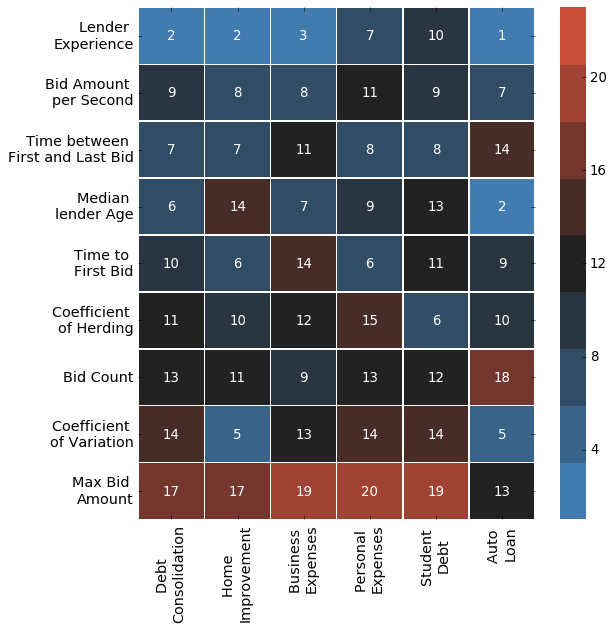

In [278]:
# import numpy as np; np.random.seed(0)
# import seaborn as sns; sns.set()
features = ["Lender \nExperience", "Bid Amount \nper Second", "Time between \nFirst and Last Bid", 
            "Median \nlender Age", "Time to \nFirst Bid",
           "Coefficient \nof Herding", "Bid Count", "Coefficient \nof Variation", "Max Bid \nAmount"]
data = [[2,2,3,7,10,1],
        [9,8,8,11,9,7],
        [7,7,11,8,8,14],
        [6,14,7,9,13,2],
        [10,6,14,6,11,9],
        [11,10,12,15,6,10],
        [13,11,9,13,12,18],
        [14,5,13,14,14,5],
        [17,17,19,20,19,13]
       ]
labels = ["Debt \nConsolidation", "Home \nImprovement", "Business \nExpenses", "Personal \nExpenses", "Student \nDebt", "Auto \nLoan"]
plt.style.use("classic")
fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.heatmap(data,
                 xticklabels=labels,
                 yticklabels=features,
#                  cmap=sns.color_palette('tab10'),
                 cmap=sns.diverging_palette(245, 17, n=9, center="dark"),
                 vmin = 1,
                 vmax= 23,
                 linewidths=.5,
                 annot=True)
ax.set_xticklabels(labels, size=13)
ax.set_yticklabels(features, size=13)
rect = fig.patch
rect.set_facecolor('white')
plt.show()

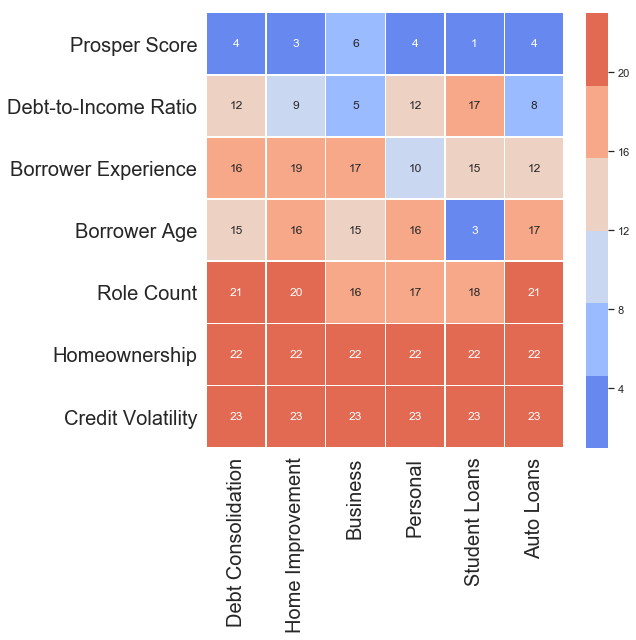

In [20]:
## import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
features = ["Prosper Score", "Debt-to-Income Ratio", "Borrower Experience", 
            "Borrower Age", "Role Count",
           "Homeownership", "Credit Volatility"]
data = [[4,3,6,4,1,4],
        [12,9,5,12,17,8],
        [16,19,17,10,15,12],
        [15,16,15,16,3,17],
        [21,20,16,17,18,21],
        [22,22,22,22,22,22],
        [23,23,23,23,23,23],
       ]
    
labels = ["Debt Consolidation", "Home Improvement", "Business", "Personal", "Student Loans", "Auto Loans"]

fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.heatmap(data,
                 xticklabels=labels,
                 yticklabels=features,
                 cmap=sns.color_palette("coolwarm"),
                 vmin = 1,
                 vmax= 23,
                 linewidths=.5,
                 annot=True)
ax.set_xticklabels(labels, size=20)
ax.set_yticklabels(features, size=20)
plt.show()

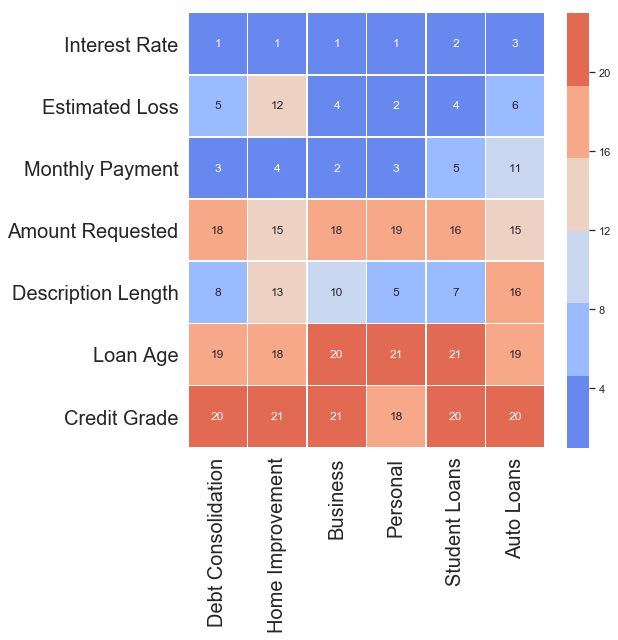

In [128]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
features = ["Interest Rate", "Estimated Loss", "Monthly Payment", 
            "Amount Requested", "Description Length",
           "Loan Age", "Credit Grade"]
data = [[1,1,1,1,2,3],
        [5,12,4,2,4,6],
        [3,4,2,3,5,11],
        [18,15,18,19,16,15],
        [8,13,10,5,7,16],
        [19,18,20,21,21,19],
        [20,21,21,18,20,20],
       ]
    
labels = ["Debt Consolidation", "Home Improvement", "Business", "Personal", "Student Loans", "Auto Loans"]

fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.heatmap(data,
                 xticklabels=labels,
                 yticklabels=features,
                 cmap=sns.color_palette("coolwarm"),
                 vmin = 1,
                 vmax= 23,
                 linewidths=.5,
                 annot=True)
ax.set_xticklabels(labels, size=20)
ax.set_yticklabels(features, size=20)
plt.show()